In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, euclidean_distances, manhattan_distances, paired_distances
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from sklearn.model_selection import RandomizedSearchCV

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
%matplotlib inline
pd.options.display.max_colwidth = 500

### 1. Исследование данных.

1. id - идентификатор пары вопросов обучающего набора <br>
2. qid1, qid2 - уникальные идентификаторы каждого вопроса <br>
3. question1, question2 - полный текст каждого вопроса <br>
4. is_duplicate - целевая переменная: 1, если question1 и question2 имеют практически одно и то же значение, и 0 в противном случае

In [2]:
data = pd.read_csv('test_questions.csv', index_col='id')
data

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0
...,...,...,...,...,...
99991,198420,198421,How can I come out of my depression?,How did you come out of depression?,0
99992,198422,198423,Is Conjuring based on a true story?,Is The Conjuring based on a true story?,1
99993,198424,198425,What business opportunities may arise as a consequence of a BREXIT?,What are the entrepreneurial opportunities that arise for EU countries because of the Brexit?,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99995
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   qid1          99996 non-null  int64 
 1   qid2          99996 non-null  int64 
 2   question1     99996 non-null  object
 3   question2     99996 non-null  object
 4   is_duplicate  99996 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.6+ MB


In [4]:
data.qid1.nunique(), data.qid2.nunique(), data.shape[0]

(99641, 99475, 99996)

Пропусков в данных нет. Некоторые вопросы повторяются.

In [5]:
data.is_duplicate.value_counts(normalize=True)

0    0.627385
1    0.372615
Name: is_duplicate, dtype: float64

Данные хорошо сбалансированны. <br>
Посмотрим на примеры объектов двух классов:

In [6]:
data[data.is_duplicate == 1].sample(5)

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
93981,186572,186573,Is it possible to change India's name into Hindustan or Bharath?,Should India change its name to Bharat/Hindustan?,1
55017,109467,109468,What are the chances of India in Rio Olympics after Sakshi Malik won bronze medal?,Can India win some more medals after Sakshi Malik won the bronze medal at Rio Olympics 2016?,1
66557,132326,132327,Does poker qualify to be called a 'sport'?,How does poker qualify as a sport?,1
58418,116208,116209,Where can I get best legal support for property transaction in Sydney?,Where can I get very friendly property transactions services in Sydney?,1
3217,6433,6434,What would be a cool way to commit suicide?,What are the possible ways to commit suicide?,1


In [7]:
data[data.is_duplicate == 0].sample(5)

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
82536,163936,163937,What are some of the best anime series I should watch?,What are the best magical and romantic anime series?,0
43183,86004,86005,What is a functional?,What is a function?,0
87936,174617,174618,How is Israel remaining a Jewish state with religious freedom?,Why is the Jewish state named after Israel?,0
32249,64277,64278,How do I copy files from a USB to the PS4?,How do I view video/movie files from a USB on a Sharp model TV?,0
6801,13584,13585,"How common is ""common"" in common sense?","How common is ""common sense""?",0


Исследуем распределение символов и слов в текстах вопросов:

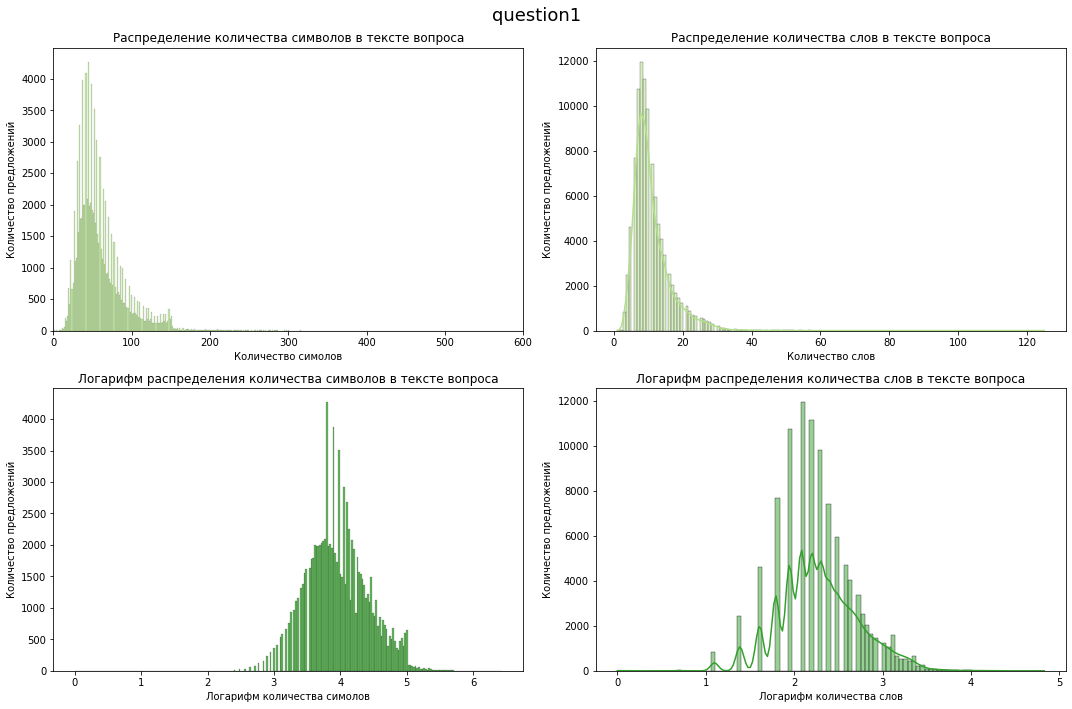

In [8]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('question1', fontsize=18)

sns.histplot(data.question1.str.len(),ax=axs[0,0], color=sns.color_palette("Paired", 8)[2])
sns.histplot(np.log(data.question1.str.len()), ax=axs[1,0], color=sns.color_palette("Paired", 8)[3])
sns.histplot([len(x.split()) for x in data['question1'].tolist()], ax=axs[0,1], kde=True, bins=150, color=sns.color_palette("Paired", 8)[2])
sns.histplot(np.log([len(x.split()) for x in data['question1'].tolist()]), ax=axs[1,1], kde=True, bins=100, color=sns.color_palette("Paired", 8)[3])

axs[0,0].set(xlabel='Количество симолов', ylabel='Количество предложений',
           title = 'Распределение количества символов в тексте вопроса')
axs[0,0].set_xlim(0,600)
axs[1,0].set(xlabel='Логарифм количества симолов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества символов в тексте вопроса')
axs[0,1].set(xlabel='Количество слов', ylabel='Количество предложений',
           title = 'Распределение количества слов в тексте вопроса')
axs[1,1].set(xlabel='Логарифм количества слов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества слов в тексте вопроса')

plt.tight_layout()
plt.show()

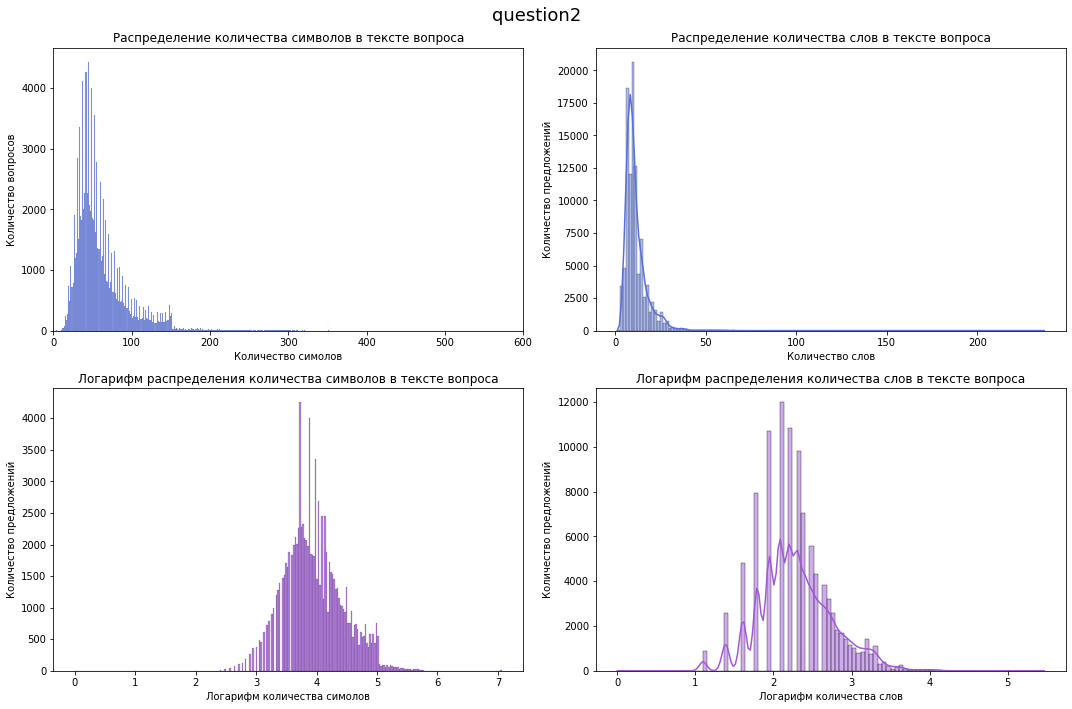

In [9]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('question2', fontsize=18)

sns.histplot(data.question2.str.len(), color=sns.color_palette("hls", 8)[5], ax=axs[0,0])
sns.histplot(np.log(data.question2.str.len()), color=sns.color_palette("hls", 8)[6], ax=axs[1,0])
sns.histplot([len(x.split()) for x in data['question2'].tolist()], ax=axs[0,1], kde=True, bins=150, color=sns.color_palette("hls", 8)[5])
sns.histplot(np.log([len(x.split()) for x in data['question2'].tolist()]), ax=axs[1,1], kde=True, bins=100, color=sns.color_palette("hls", 8)[6])

axs[0,0].set(xlabel='Количество симолов', ylabel='Количество вопросов',
           title = 'Распределение количества символов в тексте вопроса')
axs[0,0].set_xlim(0, 600)
axs[1,0].set(xlabel='Логарифм количества симолов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества символов в тексте вопроса')
axs[0,1].set(xlabel='Количество слов', ylabel='Количество предложений',
           title = 'Распределение количества слов в тексте вопроса')
axs[1,1].set(xlabel='Логарифм количества слов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества слов в тексте вопроса')

plt.tight_layout()
plt.show()

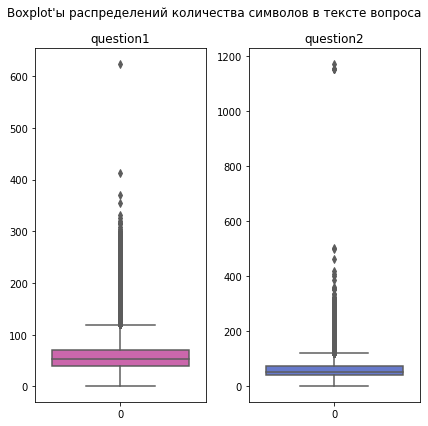

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6,6))
fig.suptitle("Boxplot'ы распределений количества символов в тексте вопроса")

sns.boxplot(data=data.question1.str.len(), ax=axs[0], color=sns.color_palette("hls", 8)[7])
sns.boxplot(data=data.question2.str.len(), ax=axs[1], color=sns.color_palette("hls", 8)[5])

axs[0].set(title = 'question1')
axs[1].set(title = 'question2')

plt.tight_layout()

Посмотрим на выбросы

In [11]:
data[data.question1.str.len() > 300].question1.sample(3)

id
90369                    If oxygen has low ionization energy compared to nitrogen because one of the p-orbital is filled with two electrons, then ionization energy of fluorine should be lower than oxygen because it has two filled p-orbitals that contains two electrons each. What causes fluorine to have higher ionization energy than oxygen?
89796    If everyone from Germany was suddenly teleported to other planet (and also got high standard of living there since I don’t want to be cruel) and other people took over the territory, would current German privacy regulations die on current German territory (get removed from political system, while being kept in historical records)?
25272                I have a laptop with 4gb RAM, AMD A8-6410 APU with AMD Radeon R5 Graphics and Radeon R5-M230 2.5gb vram, will I be able to play assassins creed syndicate with these requirements? And I am able to play gta 5 in medium settings with no lag in high settings I get slight lag. Unity isn't working

In [12]:
data[data.question2.str.len() > 450].question2.sample(3)

id
75742    Heartbreak? Heartbreak? She's my girlfriend for two months, I chose her over my girlfriend for 2 years. I like her so much to the point that I can't let her go even if she wants to end our relationship because of the other people around us most especially her family. I do the things for her that I'm not used to for a girl and I am willing to sacrifice everything just to have a little time with her. A little and limited time that I'm asking from her but she don't wanna give it to me. She's sc...
51957    Heartbreak? Heartbreak? She's my girlfriend for two months, I chose her over my girlfriend for 2 years. I like her so much to the point that I can't let her go even if she wants to end our relationship because of the other people around us most especially her family. I do the things for her that I'm not used to for a girl and I am willing to sacrifice everything just to have a little time with her. A little and limited time that I'm asking from her but she don't wanna give i

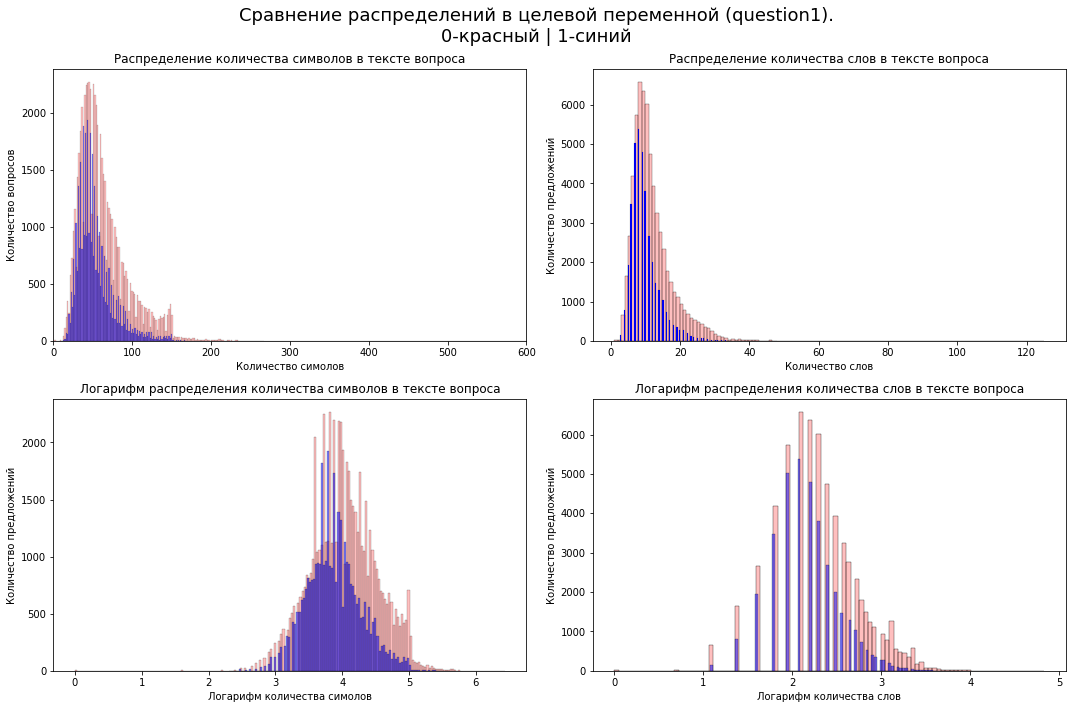

In [13]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Сравнение распределений в целевой переменной (question1).\n0-красный | 1-синий', fontsize=18)

sns.histplot(data[data.is_duplicate==0].question1.str.len(),ax=ax[0,0], alpha=0.25, color='red')
sns.histplot(data[data.is_duplicate==1].question1.str.len(),ax=ax[0,0], alpha=0.5, color='blue')

sns.histplot(np.log(data[data.is_duplicate==0].question1.str.len()), ax=ax[1,0], alpha=0.25, color='red')
sns.histplot(np.log(data[data.is_duplicate==1].question1.str.len()), ax=ax[1,0], alpha=0.5, color='blue')

sns.histplot([len(x.split()) for x in data[data.is_duplicate==0]['question1'].tolist()], ax=ax[0,1], kde=False,
             bins=125, alpha=0.25, color='red')
sns.histplot([len(x.split()) for x in data[data.is_duplicate==1]['question1'].tolist()], ax=ax[0,1], kde=False,
             bins=125, alpha=1, color='blue')

sns.histplot(np.log([len(x.split()) for x in data[data.is_duplicate==0]['question1'].tolist()]), ax=ax[1,1], kde=False,
             bins=100, alpha=0.25, color='red')
sns.histplot(np.log([len(x.split()) for x in data[data.is_duplicate==1]['question1'].tolist()]), ax=ax[1,1], kde=False,
             bins=100, alpha=0.5, color='blue')

ax[0,0].set(xlabel='Количество симолов', ylabel='Количество вопросов',
           title = 'Распределение количества символов в тексте вопроса')
ax[0,0].set_xlim(0, 600)
ax[1,0].set(xlabel='Логарифм количества симолов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества символов в тексте вопроса')
ax[0,1].set(xlabel='Количество слов', ylabel='Количество предложений',
           title = 'Распределение количества слов в тексте вопроса')
ax[1,1].set(xlabel='Логарифм количества слов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества слов в тексте вопроса')

plt.tight_layout()

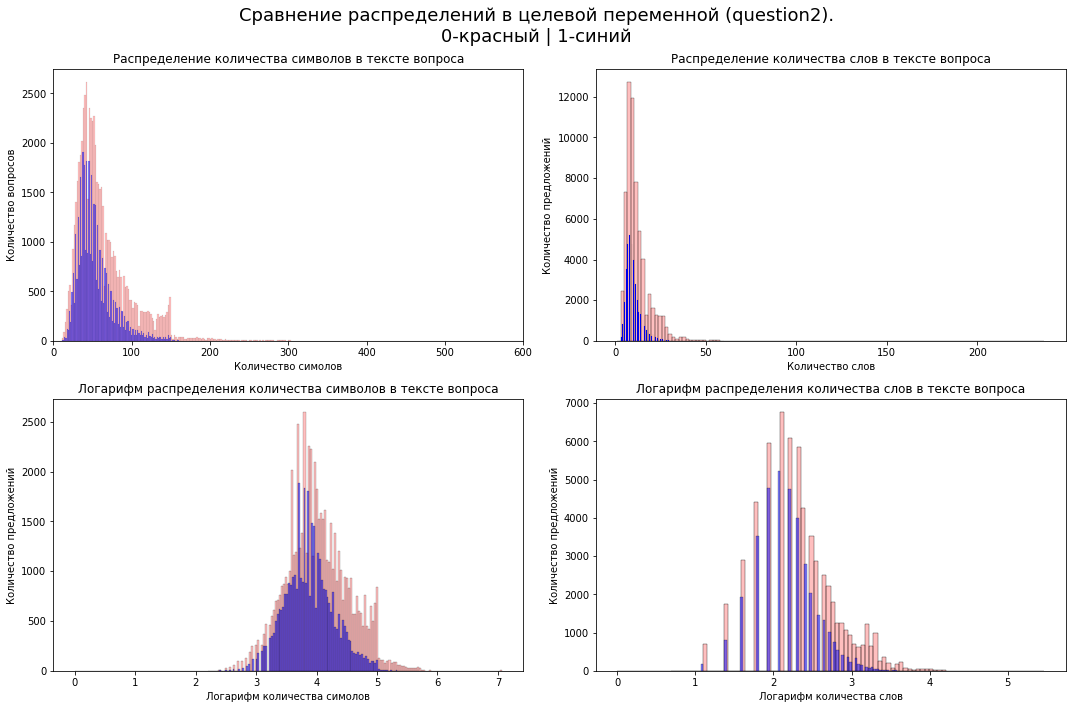

In [14]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Сравнение распределений в целевой переменной (question2).\n0-красный | 1-синий', fontsize=18)

sns.histplot(data[data.is_duplicate==0].question2.str.len(),ax=ax[0,0], alpha=0.25, color='red')
sns.histplot(data[data.is_duplicate==1].question2.str.len(),ax=ax[0,0], alpha=0.5, color='blue')

sns.histplot(np.log(data[data.is_duplicate==0].question2.str.len()), ax=ax[1,0], alpha=0.25, color='red')
sns.histplot(np.log(data[data.is_duplicate==1].question2.str.len()), ax=ax[1,0], alpha=0.5, color='blue')

sns.histplot([len(x.split()) for x in data[data.is_duplicate==0]['question2'].tolist()], ax=ax[0,1], kde=False,
             bins=125, alpha=0.25, color='red')
sns.histplot([len(x.split()) for x in data[data.is_duplicate==1]['question2'].tolist()], ax=ax[0,1], kde=False,
             bins=125, alpha=1, color='blue')

sns.histplot(np.log([len(x.split()) for x in data[data.is_duplicate==0]['question2'].tolist()]), ax=ax[1,1], kde=False,
             bins=100, alpha=0.25, color='red')
sns.histplot(np.log([len(x.split()) for x in data[data.is_duplicate==1]['question2'].tolist()]), ax=ax[1,1], kde=False,
             bins=100, alpha=0.5, color='blue')

ax[0,0].set(xlabel='Количество симолов', ylabel='Количество вопросов',
           title = 'Распределение количества символов в тексте вопроса')
ax[0,0].set_xlim(0, 600)
ax[1,0].set(xlabel='Логарифм количества симолов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества символов в тексте вопроса')
ax[0,1].set(xlabel='Количество слов', ylabel='Количество предложений',
           title = 'Распределение количества слов в тексте вопроса')
ax[1,1].set(xlabel='Логарифм количества слов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества слов в тексте вопроса')

plt.tight_layout()

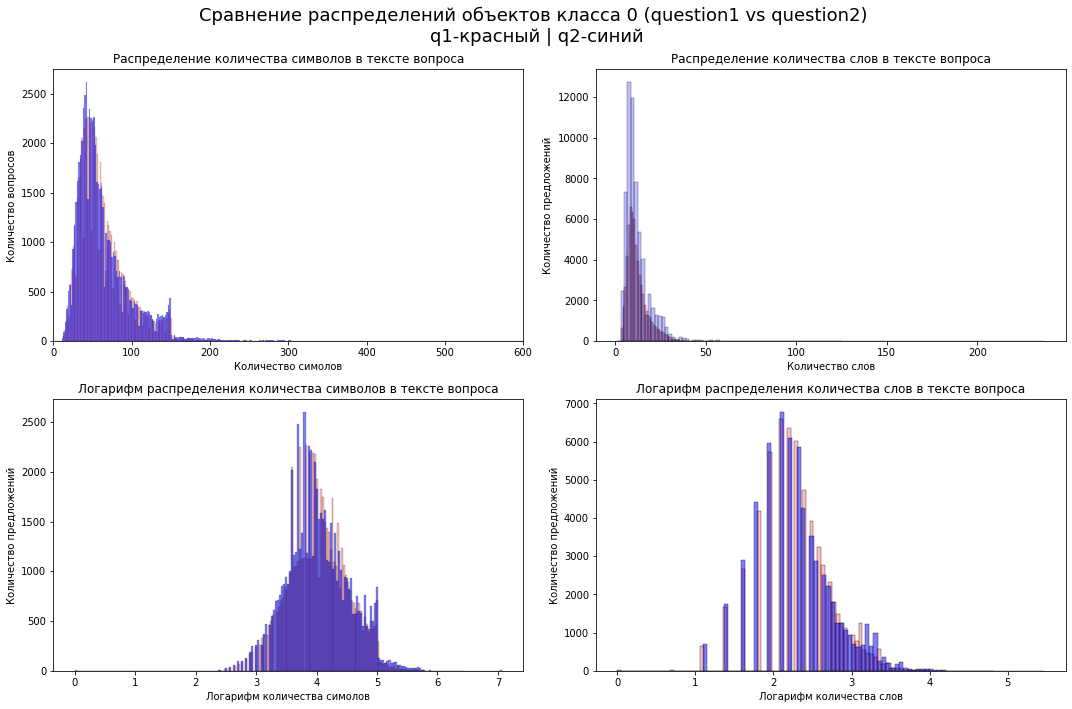

In [15]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Сравнение распределений объектов класса 0 (question1 vs question2) \nq1-красный | q2-синий', fontsize=18)

sns.histplot(data[data.is_duplicate==0].question1.str.len(),ax=ax[0,0], alpha=0.25, color='red')
sns.histplot(data[data.is_duplicate==0].question2.str.len(),ax=ax[0,0], alpha=0.5, color='blue')

sns.histplot(np.log(data[data.is_duplicate==0].question1.str.len()), ax=ax[1,0], alpha=0.25, color='red')
sns.histplot(np.log(data[data.is_duplicate==0].question2.str.len()), ax=ax[1,0], alpha=0.5, color='blue')

sns.histplot([len(x.split()) for x in data[data.is_duplicate==0]['question1'].tolist()], ax=ax[0,1], kde=False,
             bins=125, alpha=0.25, color='red')
sns.histplot([len(x.split()) for x in data[data.is_duplicate==0]['question2'].tolist()], ax=ax[0,1], kde=False,
             bins=125, alpha=0.25, color='blue')

sns.histplot(np.log([len(x.split()) for x in data[data.is_duplicate==0]['question1'].tolist()]), ax=ax[1,1], kde=False,
             bins=100, alpha=0.25, color='red')
sns.histplot(np.log([len(x.split()) for x in data[data.is_duplicate==0]['question2'].tolist()]), ax=ax[1,1], kde=False,
             bins=100, alpha=0.5, color='blue')

ax[0,0].set(xlabel='Количество симолов', ylabel='Количество вопросов',
           title = 'Распределение количества символов в тексте вопроса')
ax[0,0].set_xlim(0, 600)
ax[1,0].set(xlabel='Логарифм количества симолов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества символов в тексте вопроса')
ax[0,1].set(xlabel='Количество слов', ylabel='Количество предложений',
           title = 'Распределение количества слов в тексте вопроса')
ax[1,1].set(xlabel='Логарифм количества слов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества слов в тексте вопроса')

plt.tight_layout()

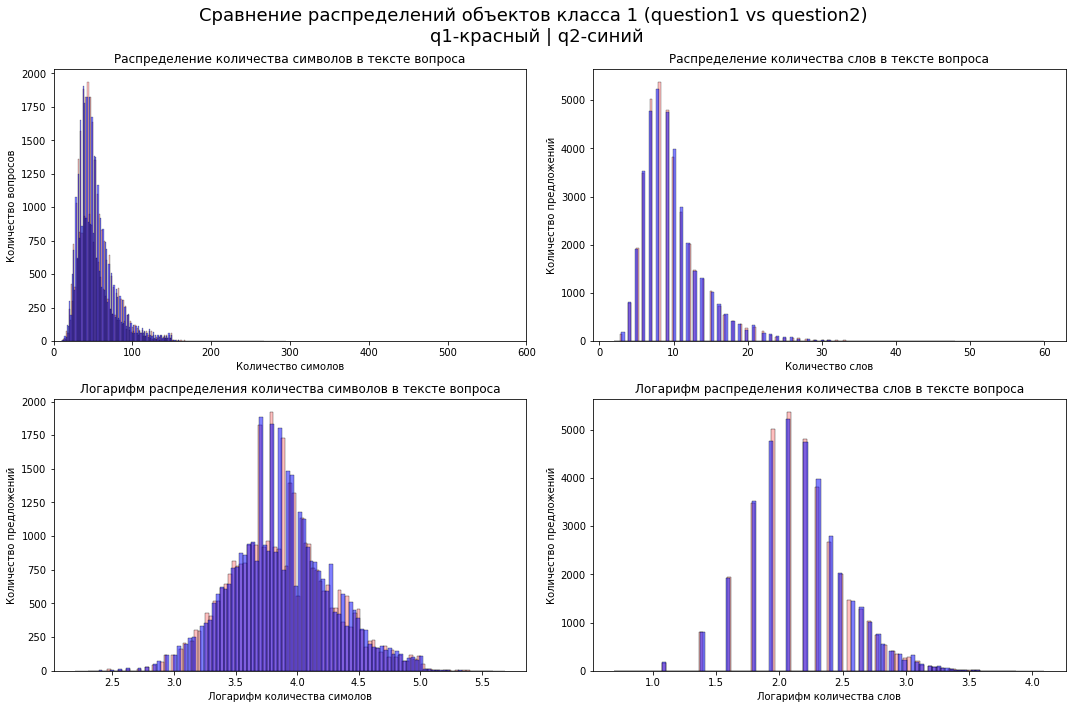

In [16]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Сравнение распределений объектов класса 1 (question1 vs question2) \nq1-красный | q2-синий', fontsize=18)

sns.histplot(data[data.is_duplicate==1].question1.str.len(),ax=ax[0,0], alpha=0.25, color='red')
sns.histplot(data[data.is_duplicate==1].question2.str.len(),ax=ax[0,0], alpha=0.5, color='blue')

sns.histplot(np.log(data[data.is_duplicate==1].question1.str.len()), ax=ax[1,0], alpha=0.25, color='red')
sns.histplot(np.log(data[data.is_duplicate==1].question2.str.len()), ax=ax[1,0], alpha=0.5, color='blue')

sns.histplot([len(x.split()) for x in data[data.is_duplicate==1]['question1'].tolist()], ax=ax[0,1], kde=False,
             bins=125, alpha=0.25, color='red')
sns.histplot([len(x.split()) for x in data[data.is_duplicate==1]['question2'].tolist()], ax=ax[0,1], kde=False,
             bins=125, alpha=0.5, color='blue')

sns.histplot(np.log([len(x.split()) for x in data[data.is_duplicate==1]['question1'].tolist()]), ax=ax[1,1], kde=False,
             bins=100, alpha=0.25, color='red')
sns.histplot(np.log([len(x.split()) for x in data[data.is_duplicate==1]['question2'].tolist()]), ax=ax[1,1], kde=False,
             bins=100, alpha=0.5, color='blue')

ax[0,0].set(xlabel='Количество симолов', ylabel='Количество вопросов',
           title = 'Распределение количества символов в тексте вопроса')
ax[0,0].set_xlim(0, 600)
ax[1,0].set(xlabel='Логарифм количества симолов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества символов в тексте вопроса')
ax[0,1].set(xlabel='Количество слов', ylabel='Количество предложений',
           title = 'Распределение количества слов в тексте вопроса')
ax[1,1].set(xlabel='Логарифм количества слов', ylabel='Количество предложений' ,
           title = 'Логарифм распределения количества слов в тексте вопроса')

plt.tight_layout()

### 2. Разбиение на обучующую и валидацонную выборки. Предобработка данных.

In [17]:
data.drop(['qid1','qid2'], axis=1, inplace=True)

X_train, X_val, y_train, y_val = train_test_split(data.iloc[:,0:2], data.is_duplicate,
                                                  test_size=0.33, random_state=1, stratify=data.is_duplicate)

In [18]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def tokenizer(sentence:str):
    sentence = sentence.lower()
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    sentence = word_tokenize(sentence)
    sentence = [i for i in sentence if i not in stopwords]
    sentence = [lemmatizer.lemmatize(i) for i in sentence]
    return sentence

In [19]:
vectorizer = TfidfVectorizer(tokenizer= lambda x: tokenizer(x))
vectorizer.fit(pd.concat([X_train['question1'], X_train['question2']]))

features1 = vectorizer.transform(X_train['question1'])
features2 = vectorizer.transform(X_train['question2'])

In [20]:
def distances(features1, features2):
    cosine_similarity = np.zeros(features1.shape[0])
    euclid_dist = np.zeros(features1.shape[0])
    manhattan_dist = np.zeros(features1.shape[0])

    for i in range(features1.shape[0]):
        cosine_similarity[i] = linear_kernel(features1[i], features2[i])
        euclid_dist[i] = euclidean_distances(features1[i], features2[i])
        manhattan_dist[i] = manhattan_distances(features1[i], features2[i])
        
    return cosine_similarity, euclid_dist, manhattan_dist

cosine_similarity, euclid_dist, manhattan_dist = distances(features1, features2)

In [21]:
X_train_sparce = hstack([features1, features2,
                         cosine_similarity.reshape(-1,1),
                         euclid_dist.reshape(-1,1),
                         manhattan_dist.reshape(-1,1),
                         
                         X_train.question1.str.len().values.reshape(-1,1), # count of symbols in questions
                         X_train.question2.str.len().values.reshape(-1,1),
                         np.array([len(x.split()) for x in X_train.question1.tolist()]).reshape(-1,1), # count of words in questions
                         np.array([len(x.split()) for x in X_train.question2.tolist()]).reshape(-1,1),
                        ])

Предобработка валидационной выборки

In [22]:
features1_val = vectorizer.transform(X_val['question1'])
features2_val = vectorizer.transform(X_val['question2'])

In [23]:
cosine_similarity_val, euclid_dist_val, manhattan_dist_val = distances(features1_val, features2_val)

In [24]:
X_val_sparce = hstack([features1_val, features2_val,
                       cosine_similarity_val.reshape(-1,1),
                       euclid_dist_val.reshape(-1,1),
                       manhattan_dist_val.reshape(-1,1),
                       
                       X_val.question1.str.len().values.reshape(-1,1),
                       X_val.question2.str.len().values.reshape(-1,1),
                       np.array([len(x.split()) for x in X_val.question1.tolist()]).reshape(-1,1),
                       np.array([len(x.split()) for x in X_val.question2.tolist()]).reshape(-1,1)
                      ])

In [25]:
# Проверка
X_val_sparce.shape[1] == X_train_sparce.shape[1]

True

### 3. Подбор гиперпараметров и обучение модели.

In [26]:
gridParams = {
    'n_estimators': np.linspace(100, 1000, 10).astype(int),
    'learning_rate': np.linspace(0, 1, 10),
    'num_leaves': [50, 75, 100, 125, 150, 200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' :  np.linspace(1, 10, 11).astype(int),
    'random_state' : [1], 
    'colsample_bytree' : [0.5, 0.6 ,0.7],
    'subsample' : [0.5, 0.6, 0.7],
    'min_data_in_leaf':[5, 6, 7, 8, 9, 10, 15, 20, 25]
    }


grid = RandomizedSearchCV(lgb.LGBMClassifier(), gridParams, cv=3, scoring='roc_auc', n_jobs=-1, n_iter=100, random_state=1)
grid.fit(X_train_sparce, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.5, 0.6, 0.7],
                                        'learning_rate': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'max_depth': array([ 1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_data_in_leaf': [5, 6, 7, 8, 9, 10,
                                                             15, 20, 25],
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'num_leaves': [50, 75, 100, 125, 150,
                                                       200],
                                        'objective': ['binary']

Передадим подобранные параметры в нашу модель и обучим на всей обучающей выборке

In [27]:
lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.set_params(**grid.best_params_)

lgb_classifier.fit(X_train_sparce, y_train)

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.1111111111111111,
               max_depth=9, min_data_in_leaf=9, n_estimators=700, num_leaves=50,
               objective='binary', random_state=1, subsample=0.6)

In [28]:
roc_auc_score(y_val, lgb_classifier.predict_proba(X_val_sparce)[:,1])

0.8646615818017505

### 4. Подбор порогов.

In [29]:
precision, recall, thresholds = precision_recall_curve(y_train, lgb_classifier.predict_proba(X_train_sparce)[:,1])
thresholds = np.append(thresholds, 1)

In [30]:
fscore = []
probas = lgb_classifier.predict_proba(X_train_sparce)[:,1]

for threshold in thresholds:
    fscore.append(f1_score(y_train, probas > threshold))
    
fscore = np.array(fscore)

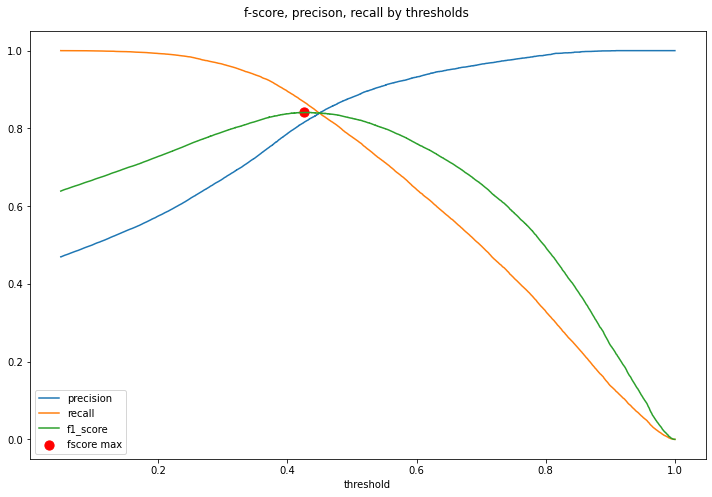

In [31]:
plt.figure(figsize=(10, 7))
plt.suptitle('f-score, precison, recall by thresholds')

plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1])
plt.plot(thresholds, fscore, color=sns.color_palette()[2])
plt.scatter(thresholds[fscore.argmax()], fscore[fscore.argmax()], color='red', s=85)

leg = plt.legend(('precision', 'recall', 'f1_score', 'fscore max'), frameon=True)
plt.xlabel('threshold') 

plt.tight_layout()
plt.show()

In [32]:
best_threshold = thresholds[fscore.argmax()]

print('f1_score max:', fscore.max(), '\nbest thresholds:', best_threshold)

f1_score max: 0.8410543286133285 
best thresholds: 0.42640229266285484


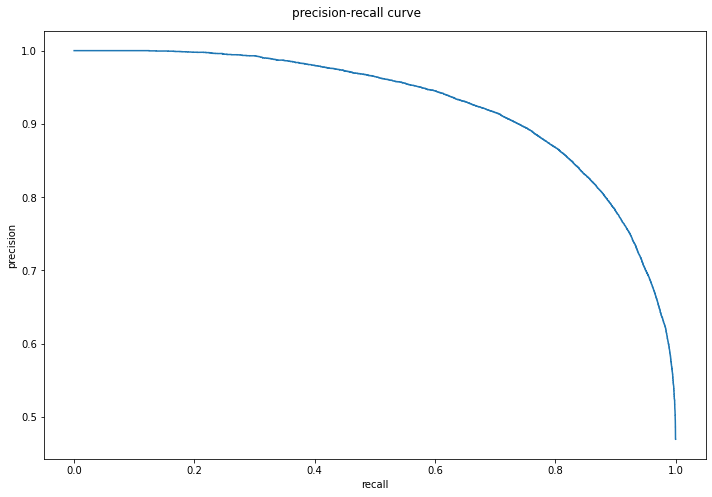

In [41]:
plt.figure(figsize=(10, 7))

plt.suptitle('precision-recall curve')
plt.plot(recall, precision, color=sns.color_palette()[0])
plt.xlabel('recall') 
plt.ylabel('precision');

plt.tight_layout()

In [42]:
f1_score(y_val, lgb_classifier.predict_proba(X_val_sparce)[:,1] > best_threshold)

0.7175484466318056

### 3. Мэтчинг вопросов

In [43]:
data = pd.read_csv('test_questions.csv', index_col='id')

In [44]:
questions = pd.concat([data[(data.qid1 > 1) & (data.qid1 <= 121424)].question1,
              data[(data.qid2 > 1) & (data.qid2 <= 121424)].question2])

other_questions = vectorizer.transform(questions)
first_question = vectorizer.transform(np.repeat(data[data.qid1 == 1].question1, questions.shape[0]))

In [45]:
cosine_similarity, euclid_dist, manhattan_dist = distances(first_question, other_questions)

In [46]:
cosine_similarity, euclid_dist, manhattan_dist = distances(first_question, other_questions)

sparce_pairs = hstack([first_question, other_questions,
                         cosine_similarity.reshape(-1,1),
                         euclid_dist.reshape(-1,1),
                         manhattan_dist.reshape(-1,1),
                         
                         questions.str.len().values.reshape(-1,1), # count of symbols in questions
                         np.repeat(data[data.qid1 == 1].question1.str.len(),questions.shape[0]).values.reshape(-1,1),
                         
                         np.array([len(x.split()) for x in questions.tolist()]).reshape(-1,1), # count of words in questions
                         np.array([len(x.split()) for x in np.repeat(data[data.qid1 == 1].question1, questions.shape[0]).tolist()]).reshape(-1,1),
                        ])

In [47]:
probas_of_pairs = lgb_classifier.predict_proba(sparce_pairs)[:,1]
print(data[data.qid1 == 1].question1.values)

pd.DataFrame([np.sort(probas_of_pairs)[-100:][::-1],
              questions.iloc[probas_of_pairs.argsort()[-100:][::-1]]
             ],
             index=['proba', 'question']).T

['What is the step by step guide to invest in share market in india?']


,proba,question
0,0.625159,What is the step by step guide to invest in share market?
1,0.614452,What will be the effect on share market after the banning of 500 and 1000 notes?
2,0.614452,What will be the effect on share market after the banning of 500 and 1000 notes?
3,0.557015,How do I invest in a share market?
4,0.557015,How do I invest in share market?
...,...,...
95,0.216986,"If you have me, you want to share me. If you share me, you don't get me. What am I?"
96,0.212138,What legal steps do I need to take to start a company?
97,0.211791,What are the steps on how to work in the United nations?
98,0.211272,What is an equity share?


In [49]:
print(data[data.qid1 == 1].question1.values)
pd.DataFrame([np.sort(cosine_similarity)[-100:][::-1],
              questions.iloc[cosine_similarity.argsort()[-100:][::-1]]
             ],
             index=['cosine_similarity', 'question']).T

['What is the step by step guide to invest in share market in india?']


,cosine_similarity,question
0,0.979633,What is the step by step guide to invest in share market?
1,0.605797,What are the first steps to invest in the Indian stock market?
2,0.565056,How do I invest in share market?
3,0.565056,How do I invest in a share market?
4,0.531093,How can I learn digital marketing step by step for free?
...,...,...
95,0.300978,Why Dhoni steps down as captain from Indian cricket?
96,0.299799,What the next step PM Modi should take after demonetization?
97,0.298413,"After demonetization and a cashless economy, what is the next step that the Indian government should take for India?"
98,0.297712,What are the steps I need to take to sell a car lease?
